In [1]:
import torch, evaluate, numpy as np, wandb, multiprocessing, random, time, os
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import (
    Compose,

    CenterCrop,
    Resize,
    Normalize,
    ToTensor,
)
testset_size = 0.3

2024-04-02 10:09:15.993051: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 10:09:16.552002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = load_dataset("imagefolder", data_dir="/home/dxd_jy/joel/Capstone/For_Training/Training_Dataset")

labels1 = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels1):
    label2id[label] = i
    id2label[i] = label

Resolving data files:   0%|          | 0/154169 [00:00<?, ?it/s]

In [3]:
model_checkpoint1 = "microsoft/beit-base-patch16-384"
image_processor1 = AutoImageProcessor.from_pretrained(model_checkpoint1)

model_checkpoint2 = "google/vit-base-patch16-224"
image_processor2 = AutoImageProcessor.from_pretrained(model_checkpoint2)

model_checkpoint3 = "google/vit-base-patch16-384"
image_processor3 = AutoImageProcessor.from_pretrained(model_checkpoint3)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [4]:
#Model 1

normalize = Normalize(mean=image_processor1.image_mean, std=image_processor1.image_std)
if "height" in image_processor1.size:
    size = (image_processor1.size["height"], image_processor1.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor1.size:
    size = image_processor1.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor1.size.get("longest_edge")

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

model_path = "/home/dxd_jy/joel/Capstone/Model/beit-base-patch16-384-10L_10E_8B_5e-05_0.3"

model = AutoModelForImageClassification.from_pretrained(
    model_path, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [5]:
#Model 2

normalize2 = Normalize(mean=image_processor2.image_mean, std=image_processor2.image_std)
if "height" in image_processor2.size:
    size2 = (image_processor2.size["height"], image_processor2.size["width"])
    crop_size2 = size2
    max_size2 = None
elif "shortest_edge" in image_processor2.size:
    size2 = image_processor2.size["shortest_edge"]
    crop_size2 = (size2, size2)
    max_size2 = image_processor2.size.get("longest_edge")

val_transforms2 = Compose(
        [
            Resize(size2),
            CenterCrop(crop_size2),
            ToTensor(),
            normalize2,
        ]
    )

def preprocess_val2(example_batch2):
    """Apply val_transforms across a batch."""
    example_batch2["pixel_values"] = [val_transforms2(image2.convert("RGB")) for image2 in example_batch2["image"]]
    return example_batch2

model_path2 = "/home/dxd_jy/joel/Capstone/Model/best-vit-base-patch16-224-10L_20E_8B_5e-05_0.3"

model2 = AutoModelForImageClassification.from_pretrained(
    model_path2, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [6]:
#Model 3

normalize3 = Normalize(mean=image_processor3.image_mean, std=image_processor3.image_std)
if "height" in image_processor3.size:
    size3 = (image_processor3.size["height"], image_processor3.size["width"])
    crop_size3 = size3
    max_size3 = None
elif "shortest_edge" in image_processor3.size:
    size3 = image_processor3.size["shortest_edge"]
    crop_size3 = (size3, size3)
    max_size3 = image_processor3.size.get("longest_edge")

val_transforms3 = Compose(
        [
            Resize(size3),
            CenterCrop(crop_size3),
            ToTensor(),
            normalize3,
        ]
    )

def preprocess_val3(example_batch3):
    """Apply val_transforms across a batch."""
    example_batch3["pixel_values"] = [val_transforms3(image3.convert("RGB")) for image3 in example_batch3["image"]]
    return example_batch3

model_path3 = "/home/dxd_jy/joel/Capstone/Model/vit-base-patch16-384-10L_15E_8B_5e-05_0.3_WithAug"

model3 = AutoModelForImageClassification.from_pretrained(
    model_path3, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [7]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""

    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)

    accuracy_results    = accuracy.compute(predictions=predictions, references=labels)
    f1_results          = f1.compute(predictions=predictions, references=labels, average="weighted")
    precision_results   = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_results      = recall.compute(predictions=predictions, references=labels, average="weighted")
    combined_results    = {**accuracy_results, **f1_results, **precision_results, **recall_results}
 
    return combined_results

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [8]:
name = "Test123"
args = TrainingArguments(
    name,
    remove_unused_columns=          False,
    evaluation_strategy=            "epoch",
    save_strategy=                  "epoch",
    gradient_accumulation_steps=    4,
    warmup_ratio=                   0.1,
    per_device_eval_batch_size=     32,
    log_level=                      "info",
    logging_steps=                  1,
    logging_strategy=               "epoch",
    load_best_model_at_end=         True,
    save_total_limit=               1, 
    metric_for_best_model=          "accuracy",
)

In [9]:
seed = 1026847926404610400
#seed = random.randint(1, 2**63 - 1)

# split up training into training + validation and evaluation
splits = ds["train"].train_test_split(test_size=testset_size, stratify_by_column="label", seed=seed)
splits2 = splits['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=seed)
splits3 = splits['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=seed)
splits4 = splits['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=seed)

eval_ds2 = splits2['test']
eval_ds3 = splits3['test']
eval_ds4 = splits4['test']
eval_ds2.set_transform(preprocess_val)   
eval_ds3.set_transform(preprocess_val2)
eval_ds4.set_transform(preprocess_val3)

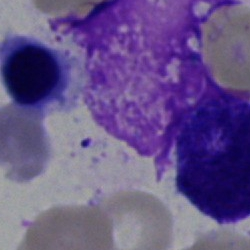

In [10]:
eval_ds2[0]['image']

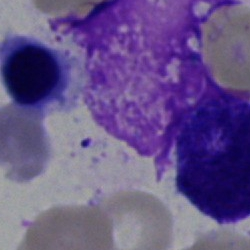

In [11]:
eval_ds3[0]['image']

In [12]:
trainer1 = Trainer(
    model,
    args,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

final1 = trainer1.predict(test_dataset=eval_ds2)

***** Running Prediction *****
  Num examples = 23126
  Batch size = 32


In [13]:
trainer2 = Trainer(
    model2,
    args,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

final2 = trainer2.predict(test_dataset=eval_ds3)

***** Running Prediction *****
  Num examples = 23126
  Batch size = 32


In [14]:
trainer3 = Trainer(
    model3,
    args,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

final3 = trainer3.predict(test_dataset=eval_ds4)

***** Running Prediction *****
  Num examples = 23126
  Batch size = 32


In [26]:
weight1 = 0.9229
weight2 = 0.9653
weight3 = 0.9183

In [23]:
np.argmax(final1.predictions[1])

4

In [34]:
from collections import Counter

final_ensemble_pred = []
for x in range(len(final1.label_ids)):
    temp = []
    temp.append(np.argmax(final1.predictions[x]))
    temp.append(np.argmax(final2.predictions[x]))
    temp.append(np.argmax(final3.predictions[x]))
    print(temp)
    count = Counter(temp)
    final_ensemble_pred.append(count.most_common(1)[0][0])

[0, 0, 0]
[4, 4, 4]
[7, 7, 7]
[7, 7, 7]
[0, 0, 0]
[8, 8, 8]
[0, 0, 0]
[2, 2, 2]
[1, 1, 1]
[8, 8, 8]
[3, 3, 4]
[7, 7, 7]
[2, 2, 2]
[2, 2, 2]
[7, 7, 7]
[2, 2, 2]
[7, 7, 7]
[0, 0, 0]
[5, 5, 5]
[1, 1, 1]
[8, 8, 8]
[1, 2, 1]
[7, 7, 7]
[4, 4, 4]
[0, 0, 0]
[2, 2, 2]
[2, 2, 2]
[4, 4, 4]
[2, 2, 2]
[7, 7, 7]
[4, 4, 0]
[2, 2, 2]
[4, 4, 4]
[1, 1, 1]
[1, 1, 1]
[7, 7, 7]
[4, 4, 4]
[7, 7, 7]
[4, 4, 4]
[2, 2, 2]
[0, 0, 0]
[2, 1, 1]
[7, 7, 7]
[0, 0, 0]
[6, 6, 6]
[2, 2, 2]
[4, 4, 4]
[2, 2, 2]
[7, 7, 7]
[0, 0, 0]
[2, 2, 2]
[7, 7, 7]
[2, 2, 2]
[1, 1, 1]
[7, 7, 7]
[2, 2, 2]
[7, 7, 7]
[7, 7, 7]
[7, 7, 7]
[4, 4, 4]
[2, 2, 2]
[7, 7, 7]
[7, 7, 7]
[7, 7, 7]
[2, 2, 2]
[4, 4, 4]
[0, 0, 0]
[2, 2, 2]
[0, 0, 0]
[2, 2, 2]
[4, 4, 4]
[3, 3, 3]
[8, 8, 8]
[1, 1, 1]
[1, 1, 1]
[6, 6, 6]
[4, 4, 4]
[3, 3, 3]
[4, 5, 4]
[1, 1, 1]
[7, 6, 7]
[2, 2, 2]
[2, 2, 2]
[7, 7, 7]
[2, 2, 2]
[2, 2, 2]
[7, 7, 7]
[1, 1, 1]
[6, 6, 6]
[2, 2, 2]
[2, 2, 2]
[9, 9, 9]
[2, 2, 2]
[0, 0, 0]
[7, 7, 7]
[7, 7, 7]
[9, 9, 9]
[4, 4, 4]
[1, 1, 1]
[9, 9, 9]


In [38]:
count = 0
for x in range(len(final1.label_ids)):
    if final1.label_ids[x] != final_ensemble_pred[x]:
        count += 1
        print(x)

21
51
54
78
80
87
106
126
180
234
249
261
265
285
289
304
367
378
401
405
435
470
476
479
485
492
505
521
533
558
571
580
591
593
621
634
654
662
672
683
696
702
705
728
736
740
754
796
798
804
815
842
854
856
871
878
885
886
907
919
935
949
969
986
1011
1047
1069
1090
1096
1108
1115
1125
1158
1177
1178
1196
1200
1221
1246
1248
1250
1260
1265
1267
1282
1305
1310
1341
1344
1347
1351
1368
1370
1375
1376
1386
1391
1407
1412
1433
1445
1517
1522
1534
1558
1567
1571
1574
1580
1588
1615
1620
1661
1723
1742
1752
1759
1764
1766
1784
1810
1812
1813
1821
1847
1859
1879
1890
1918
1920
1927
1947
2005
2042
2045
2078
2083
2090
2111
2133
2135
2149
2179
2212
2246
2267
2271
2290
2332
2366
2388
2401
2444
2461
2464
2473
2496
2506
2518
2525
2526
2529
2560
2574
2589
2591
2604
2696
2763
2767
2775
2780
2788
2803
2812
2857
2860
2900
2903
2963
2965
2968
2973
2975
2982
2992
3001
3020
3039
3055
3059
3061
3072
3080
3082
3091
3107
3118
3121
3151
3152
3184
3229
3259
3271
3294
3315
3395
3486
3495
3497
3499
3500
3562


In [40]:
final_ensemble_pred[21]

1

In [41]:
final1.label_ids[21]

2

In [35]:
accuracy_results = accuracy.compute(predictions=final_ensemble_pred, references=final1.label_ids)

In [36]:
accuracy_results

{'accuracy': 0.9393323531955375}